<a href="https://colab.research.google.com/github/Thanisthani/Region_detection_unmask_mobilenet/blob/main/Region_detection_keras_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import lib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

Mount g drive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Add dataset path

In [ ]:
import pathlib
data_dir='/content/gdrive/MyDrive/Region_detection/data/new_images'
data_dir = pathlib.Path(data_dir).with_suffix('')

Pre process the data

In [ ]:

# Define the image size and batch size
img_size = (160, 160)
batch_size = 32

# Load the training and validation datasets
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.


Find clas names

In [ ]:
class_names = train_dataset.class_names
print(class_names)

['EastAsian', 'SouthAsian']


Config dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Data agumentation

In [ ]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(160,
                                  160,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visulaize data agumentation

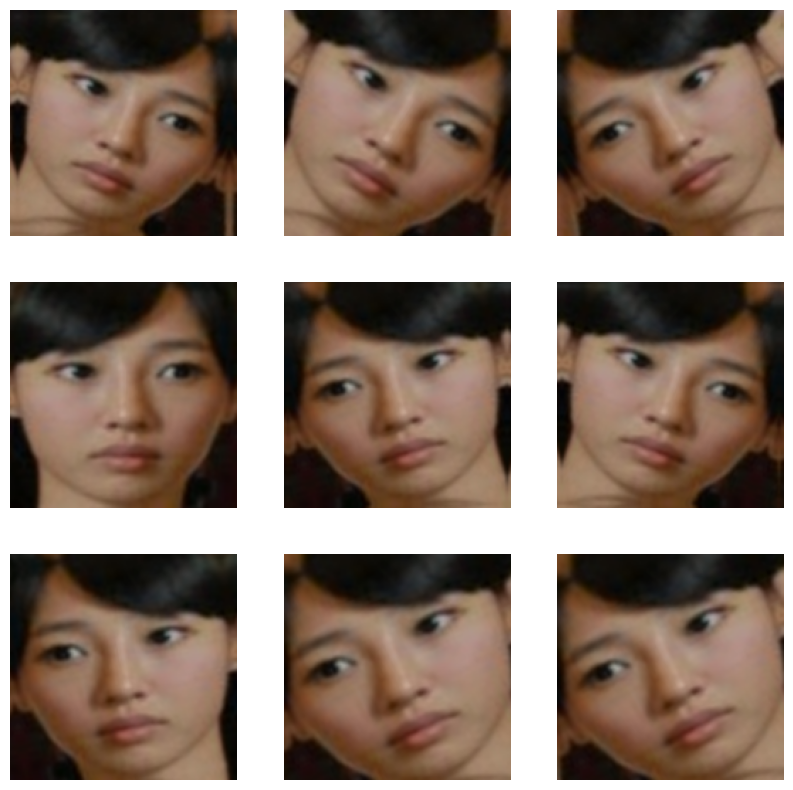

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

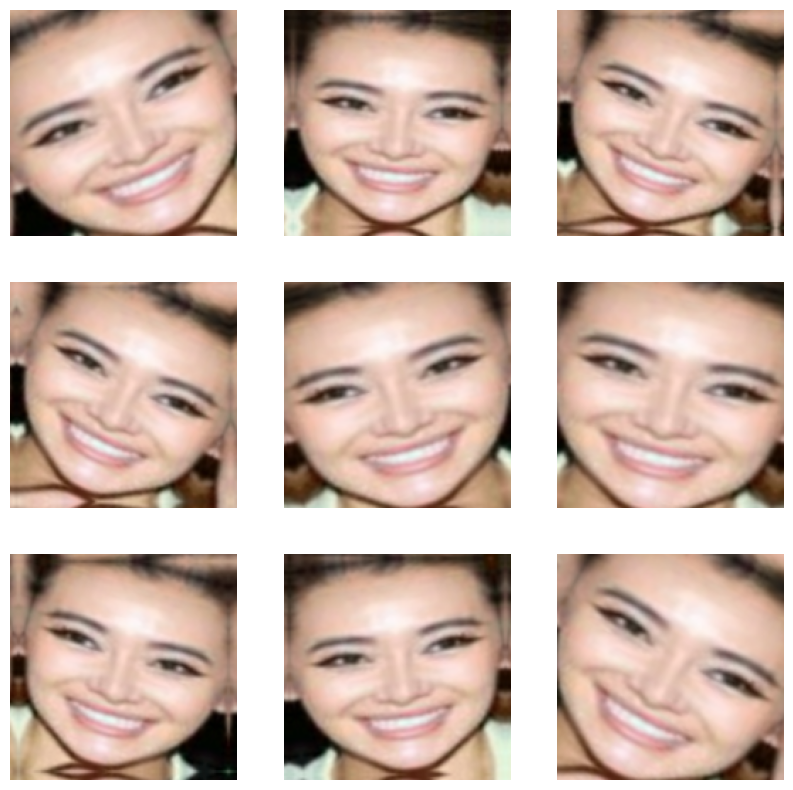

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Load pre trained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


Freeze convolutional base

In [ ]:
pretrained_model.trainable = False

Add classification head

In [ ]:
model = models.Sequential([
  pretrained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(1)
])

Compile model

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train model

In [ ]:
epochs = 20
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/20
3/3 [==============================] - 0s 91ms/step - loss: 0.5137 - accuracy: 0.7375 - val_loss: 0.4523 - val_accuracy: 0.8000
Epoch 2/20
3/3 [==============================] - 1s 193ms/step - loss: 0.5062 - accuracy: 0.7375 - val_loss: 0.4449 - val_accuracy: 0.8000
Epoch 3/20
3/3 [==============================] - 1s 122ms/step - loss: 0.4992 - accuracy: 0.7375 - val_loss: 0.4385 - val_accuracy: 0.8000
Epoch 4/20
3/3 [==============================] - 1s 135ms/step - loss: 0.4921 - accuracy: 0.7375 - val_loss: 0.4318 - val_accuracy: 0.8000
Epoch 5/20
3/3 [==============================] - 1s 190ms/step - loss: 0.4854 - accuracy: 0.7625 - val_loss: 0.4257 - val_accuracy: 0.8000
Epoch 6/20
3/3 [==============================] - 1s 123ms/step - loss: 0.4792 - accuracy: 0.7625 - val_loss: 0.4197 - val_accuracy: 0.8000
Epoch 7/20
3/3 [==============================] - 1s 107ms/step - loss: 0.4728 - accuracy: 0.7625 - val_loss: 0.4138 - val_accuracy: 0.8000
Epoch 8/20
3/3 [=====

Evaluation

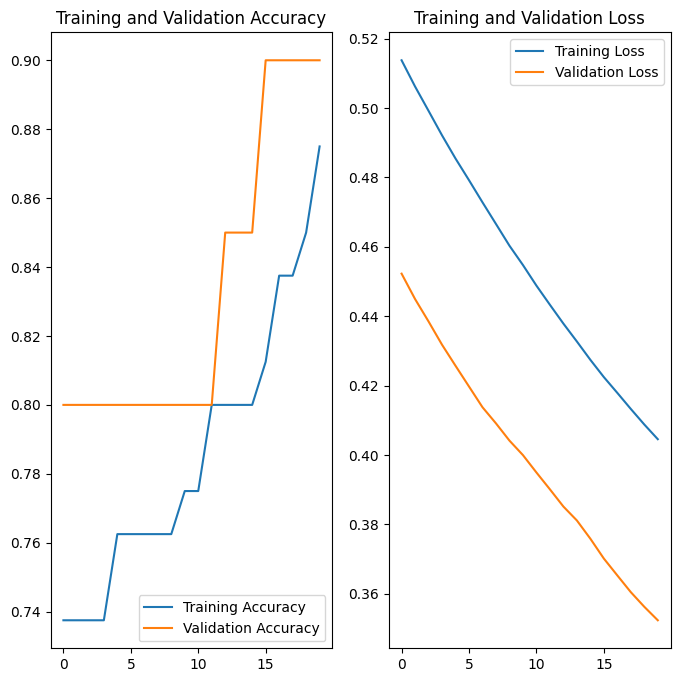

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 2)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing model

In [ ]:
def predict_image(model, img_path):
    # Preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Make predictions
    predictions = model.predict(img_array)

    print(predictions[0] )
    # Decode the predictions to the original labels
    predicted_label = "East Asian" if predictions[0] > 0 else "South asian"

    return predicted_label

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    # Load the image file, resizing it to the input size of our model
    img = image.load_img(img_path, target_size=img_size)

    # Convert the image to array
    img_array = image.img_to_array(img)

    # Normalize the image pixels
    img_array /= 255.0

    # Expand dimensions to fit the batch size
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [ ]:
img_path = "/content/gdrive/MyDrive/Region_detection/data/test_image/sa4.jpg"  # Replace with the path of your image
predicted_label = predict_image(model, img_path)

print(f"The model predicts that the image is a {predicted_label}")

1/1 [==============================] - 0s 23ms/step
[1.3949302]
The model predicts that the image is a East Asian


Find accuracy

In [ ]:
# Evaluate on the validation set
evaluation = model.evaluate(validation_dataset)

# Print the evaluation results
print(f"Evaluation Results: {evaluation}")
print(f"Accuracy: {evaluation[1]*100:.2f}%")
# print(f"Precision: {evaluation[2]*100:.2f}%")
# print(f"Recall: {evaluation[3]*100:.2f}%")

1/1 [==============================] - 0s 116ms/step - loss: 0.3524 - accuracy: 0.9000
Evaluation Results: [0.3523930609226227, 0.8999999761581421]
Accuracy: 90.00%
